# Notebook Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Math


import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.insert(1, '../')

from moments_toolkit import moments_toolkit

from utilities import jackknife

# Data Reading

In [2]:
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/2PointCorrelation/"


opAnalyzer = moments_toolkit(p3fold, p2fold,
                            skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data_extended_p0_q0",
                            operator_folder= "../operator_database",
                            momentum='PX0_PY0_PZ0',
                            insertion_momentum = 'qx0_qy0_qz0',
                            tag_2p='hspectrum',
                            max_n=2 #max_n=3
                            )


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



# Std Analysis

In [3]:
p2corr = opAnalyzer.get_p2corr() #shape = (nconf, latticeT)

latticeT = opAnalyzer.latticeT
nconf = opAnalyzer.nconf

"(nconf, latticeT)"
p2corr.shape

'(nconf, latticeT)'

(212, 48)

In [4]:
mean_normal = np.mean(p2corr, axis=0)
std_normal = np.std(p2corr, axis=0, ddof=1) /np.sqrt(nconf)

mean_jack, std_jack, cov_jack = jackknife(p2corr, lambda x: np.mean(x, axis=0), jack_axis_list=0, binsize=1, time_axis=-1)

In [5]:
##function that resample the given arrays along the innermost axis (credit: https://stackoverflow.com/a/53236272)
#def resamples_last_axis(arr, reps):
#    """
#    Function used to resample with replacement the innermost axis of the given array (credit: https://stackoverflow.com/a/53236272)
#    
#    Input:
#        - arr: the input array to be resampled (along the innermost axis)
#        - reps: the number of resamples that is required
#    
#    Output:
#        - resampled_array: the input arry resampled along the last axis, shape = (reps,) + arr.shape
#    """
#
#    n = arr.shape[-1]
#
#
#    # create an array to shift random indexes as needed
#    shift = np.repeat(np.arange(0, arr.size, n), n).reshape(arr.shape)
#
#    # get a flat view of the array
#    arrflat = arr.ravel()
#
#    # sample the array by generating random ints and shifting them appropriately
#    return np.array([arrflat[np.random.randint(0, n, arr.shape) + shift] 
#                     for i in range(reps)])
#
#
##function that generates the bootstap resampled of the given array along a specified axis
#def bootstrap_resamples(array: np.ndarray, axis:int, Nres:int):
#    """
#    Function performing the bootstrap resampling (sample with replacement) of the input array along a given axis
#    (obtain with minimal modifications to the code given in: https://stackoverflow.com/a/53236272)
#    
#    Input:
#        - array: input array to be resampled
#        - axis: the axis over which to perform the resampling with replacement
#        - Nres: the number of required resamples
#    
#    Output:
#        - resamples_array: the array with the resamples, shape = (Nres,) + array.shape
#    """
#
#    #we read the number of dimensions of the input array
#    ndim = array.ndim
#
#    #input control on the axis parameter
#    if axis >= ndim or axis<-ndim:
#        raise ValueError(f"The input array has shape {array.shape}, so axis can take values in the range {-ndim}, ..., {ndim}, extremes included, but axis={axis} were given.")
#    
#    #cast axis to a postive number in the correct range
#    axis = (axis + array.ndim) % array.ndim
#
#    #we swap the array as to have the axis to resample on the last axis
#    swapped_array = np.swapaxes(array,axis1=axis, axis2=-1)
#
#    #we resample along the last axis
#    resamples_array = resamples_last_axis(swapped_array,Nres)
#
#    #we swap again the input axis with the last one (with the +1 taking into account now there is also the resample dimension)
#    return np.swapaxes(resamples_array, axis1=axis+1, axis2=-1)

In [6]:
##function that generates the bootstap resampled of the given array along a specified axis
#def bootstrap(array: np.ndarray, axis:int, Nres:int):
#    """
#    Function performing the bootstrap resampling (sample with replacement) of the input array along a given axis
#    (obtain with minimal modifications to the code given in: https://stackoverflow.com/a/53236272)
#    
#    Input:
#        - array: input array to be resampled
#        - axis: the axis over which to perform the resampling with replacement
#        - Nres: the number of required resamples
#    
#    Output:
#        - resamples_array: the array with the resamples, shape = (Nres,) + array.shape
#    """
#
#    #we read the number of dimensions of the input array
#    ndim = array.ndim
#
#    #input control on the axis parameter
#    if axis >= ndim or axis<-ndim:
#        raise ValueError(f"The input array has shape {array.shape}, so axis can take values in the range {-ndim}, ..., {ndim}, extremes included, but axis={axis} were given.")
#    
#    #cast axis to a postive number in the correct range
#    axis = (axis + array.ndim) %array.ndim
#
#    #we swap the array as to have the axis to resample on the last axis
#    swapped_array = np.swapaxes(array,axis1=axis, axis2=-1)
#
#    #we resample along the last axis
#    resamples_array = resamples_last_axis(swapped_array,Nres)
#
#    #we swap again the input axis with the last one (with the +1 taking into account now there is also the resample dimension)
#    return np.swapaxes(resamples_array, axis1=axis+1, axis2=-1)

In [7]:
from utilities import bootstrap_resamples

Nres=150

p2corr_res = bootstrap_resamples(in_array_list=p2corr, bootstrap_axis_list=0, Nres=Nres, sample_per_resamples=200)

"(Nres, Nconf, latticeT)"
p2corr_res[0].shape

'(Nres, Nconf, latticeT)'

(200, 48)

In [10]:
std_bst = np.std( np.mean(p2corr_res,axis=1), axis=0, ddof=1)

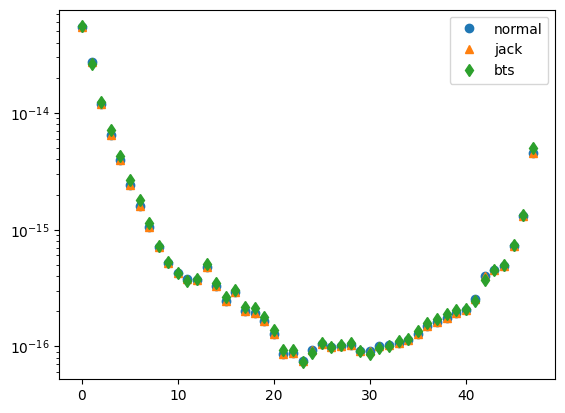

In [11]:
_ = plt.plot(np.arange(latticeT), std_normal, 'o',label="normal")

_ = plt.plot(np.arange(latticeT), std_jack, '^', label="jack")

_ = plt.plot(np.arange(latticeT), std_bst, 'd', label="bts")

_ = plt.legend()

plt.yscale("log")

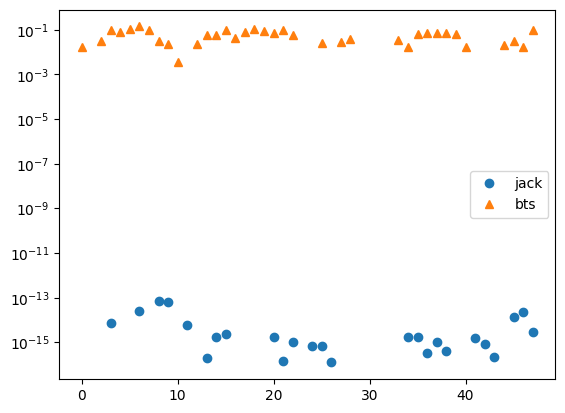

In [12]:
_ = plt.plot(np.arange(latticeT), (std_jack-std_normal)/std_normal, 'o',label="jack")

_ = plt.plot(np.arange(latticeT), (std_bst-std_normal)/std_normal, '^',label="bts")

_ = plt.legend()


plt.yscale("log")

In [13]:
Nconf = 10
latT = 12

Nres = 6
Conf_per_Res = 8

ok = np.arange(1,Nconf*latT+1).reshape((Nconf,latT)) #say Nconf=10, latT=12
ok

selection = np.random.randint(0,Nconf, Conf_per_Res) #one selection = one resample
selection

np.take( ok ,indices=np.arange(ok.shape[0]), axis=1)[selection]

array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12],
       [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
       [ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36],
       [ 37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48],
       [ 49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60],
       [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72],
       [ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84],
       [ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96],
       [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108],
       [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]])

array([5, 9, 7, 5, 8, 4, 9, 1])

array([[ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70],
       [109, 110, 111, 112, 113, 114, 115, 116, 117, 118],
       [ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94],
       [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70],
       [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106],
       [ 49,  50,  51,  52,  53,  54,  55,  56,  57,  58],
       [109, 110, 111, 112, 113, 114, 115, 116, 117, 118],
       [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22]])

In [14]:
Nconf = 10
latT = 12
Nop = 2

Nres = 3
Conf_per_Res = 8

conf_axis=1
ok = np.arange(1,Nconf*Nop*latT+1).reshape((Nop,Nconf,latT)) #say Nconf=10, latT=12
ok

selection = np.random.randint(0,Nconf, Conf_per_Res) #one selection = one resample
selection

#np.take( ok ,indices=np.arange(ok.shape[-1]), axis=-1)#[selection]
#np.take( ok ,indices=np.arange(ok.shape[0]), axis=-1)#[selection].shape
#ok[selection]
#ok[selection].shape

np.take(ok, indices = selection, axis=conf_axis)
np.take(ok, indices = selection, axis=conf_axis).shape

array([[[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12],
        [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
        [ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36],
        [ 37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48],
        [ 49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60],
        [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72],
        [ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84],
        [ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96],
        [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108],
        [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]],

       [[121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132],
        [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
        [145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156],
        [157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168],
        [169, 170,

array([8, 4, 7, 8, 8, 6, 1, 1])

array([[[ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108],
        [ 49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60],
        [ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96],
        [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108],
        [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108],
        [ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84],
        [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
        [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24]],

       [[217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228],
        [169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180],
        [205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216],
        [217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228],
        [217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228],
        [193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204],
        [133, 134,

(2, 8, 12)

In [15]:
ok.shape[:1] + (8,) + ok.shape[1+1:] 

(2, 8, 12)

In [16]:
selection_list = [np.random.randint(0,Nconf, Conf_per_Res) for _ in range(Nres)]

selection_list

[array([5, 9, 2, 1, 2, 9, 8, 6]),
 array([9, 4, 7, 7, 8, 5, 9, 5]),
 array([0, 1, 4, 2, 2, 8, 5, 9])]

In [17]:
np.take(ok, indices = selection_list, axis=conf_axis).shape
np.moveaxis( np.take(ok, indices = selection_list, axis=conf_axis), source=conf_axis, destination=0).shape
np.moveaxis( np.take(ok, indices = selection_list, axis=conf_axis), source=conf_axis, destination=0)

(2, 3, 8, 12)

(3, 2, 8, 12)

array([[[[ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72],
         [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120],
         [ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36],
         [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
         [ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36],
         [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120],
         [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108],
         [ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84]],

        [[181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192],
         [229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240],
         [145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156],
         [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
         [145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156],
         [229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240],
    

In [18]:
Nconf=10
latT=12

Nres = 3
sampl_per_resample=11

ok = np.arange(1,Nconf*latT+1).reshape((Nconf,latT))
ok

array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12],
       [ 13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
       [ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36],
       [ 37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48],
       [ 49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60],
       [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72],
       [ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84],
       [ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96],
       [ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108],
       [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]])

In [20]:
bootstrap_resamples(in_array_list=ok, bootstrap_axis_list=0, Nres=Nres, sample_per_resamples=sampl_per_resample).shape

(3, 11, 12)